In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Dense
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from keras import backend as k
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import pandas as pd
import cv2
import gc

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

1. We load the Faces Dataset where we train on only 100 images of 128 * 128 resolution. We will upscale images of 32 * 32 resolution.

In [3]:
base_dir = 'lfw_images/lfw_funneled'

# List to store image arrays
hr_img = []
lr_img = []

# Loop through each folder (person) in the base directory
for person in os.listdir(base_dir):

    person_dir = os.path.join(base_dir, person)
    
    # Check if the item is a directory
    if os.path.isdir(person_dir):
        
        # Loop through each image file in the person's directory
        for image_file in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_file)
            
            # Read the image using OpenCV
            img = cv2.imread(image_path)
            
            # Convert the image to RGB (OpenCV uses BGR by default)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_rgb = img_rgb/255
            hr = cv2.resize(img_rgb,(128,128),interpolation=cv2.INTER_CUBIC)
            lr = cv2.resize(img_rgb,(32,32),interpolation=cv2.INTER_CUBIC)
            lr = cv2.resize(lr,(128,128),interpolation=cv2.INTER_CUBIC)
            
            # Append the image array to the list
            hr_img.append(hr)
            lr_img.append(lr)
            
hr_img = np.array(hr_img[:300])
lr_img = np.array(lr_img[:300])

2. We add noise linearly to each image for total 1000 timesteps, and get the  noisy image and noise for each corrosponding image and time step.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


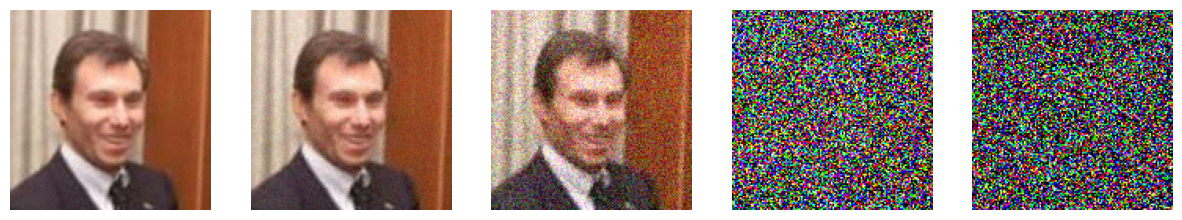

In [4]:
timesteps = 1000

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)


def add_noise(x_0, t):
    noise = np.random.normal(size=x_0.shape)
    sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), [-1, 1, 1, 1])
    one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), [-1, 1, 1, 1])
    noisy_img = sqrt_alpha_bar_t  * x_0 + one_minus_sqrt_alpha_bar_t  * noise
    return tf.convert_to_tensor(noisy_img),tf.convert_to_tensor(noise)

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([1,5,29,499,999]):
    noisy_im, noise = add_noise(hr_img[0], np.array([i,]))
    noisy_im = noisy_im[0] # 1,28,28,1 shape
    plt.subplot(1, 5, index+1)
    plt.axis('off')
    plt.imshow(noisy_im)


3. Define the UNET model that takes input as noisy image and outputs noise as prediction.

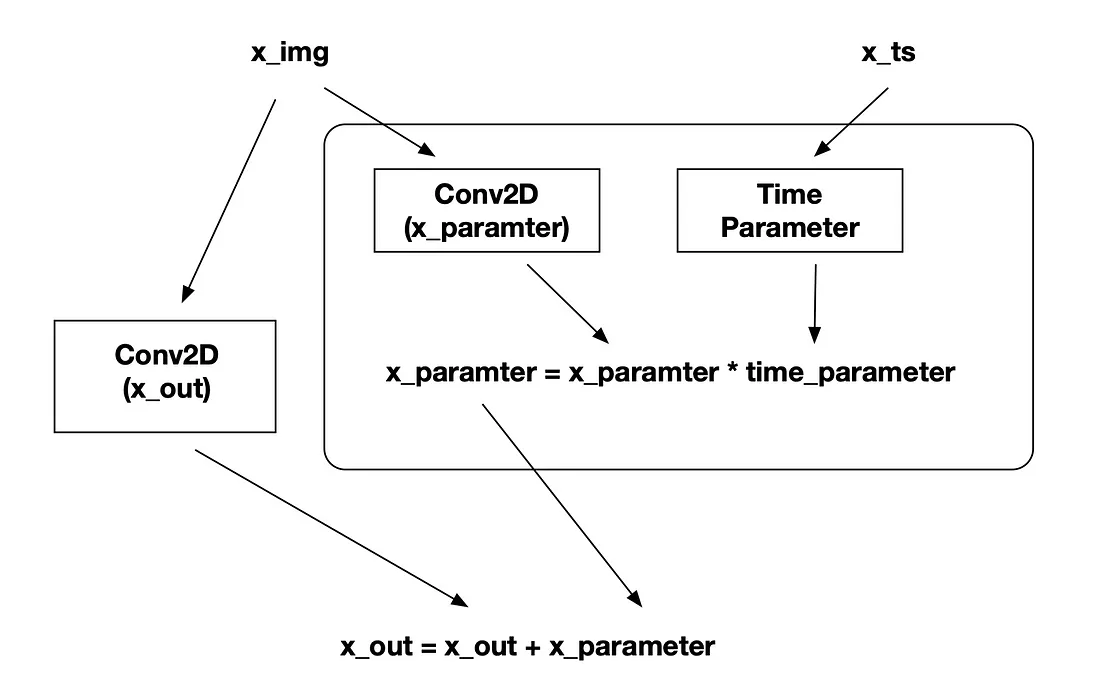

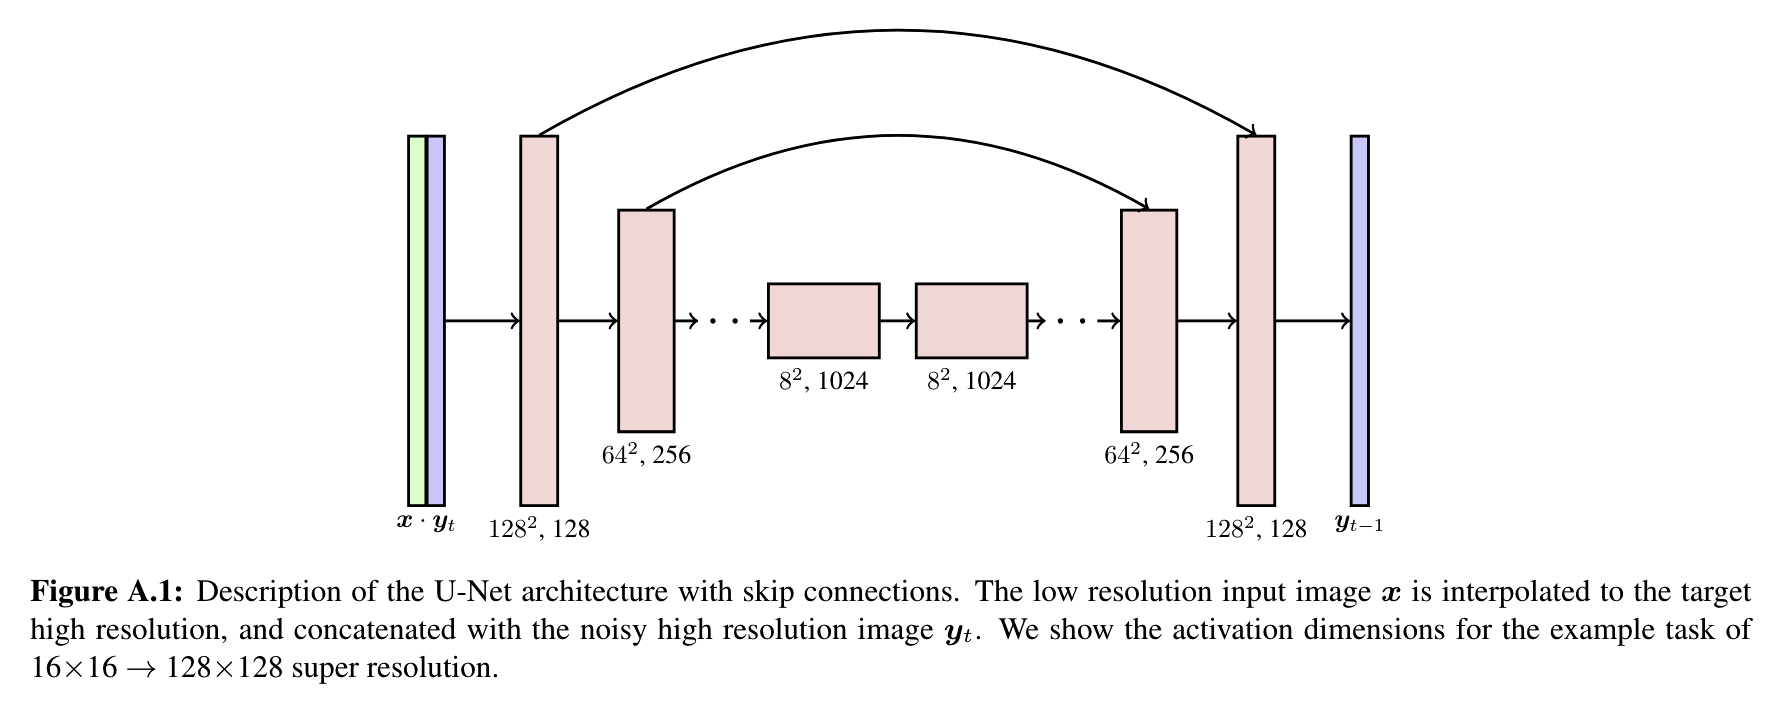

It's important to mention, as highlighted in the SR3 paper, 

1. the training process involves feeding the model with bicubic upscaled images. 

2. This approach guides the model to understand the direction for super resolution sampling.

In [5]:
def block(x_img, x_ts):
    
    x_parameter = layers.Conv2D(64, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(64)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 64))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(64, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

def make_model():
    x1_ = x_input1 = layers.Input(shape=(128,128, 3), name='x_input1')    # input noisy image
    x2_ = x_input2 = layers.Input(shape=(128,128, 3), name='x_input2')   # input bicubic upscaled image
    
    x = tf.concat([x1_,x2_],axis=3)  # concatenate input noisy image and input bicubic upscaled image along the Channel axis 
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(64)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(64)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(32*32*64)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((32,32,64))(x)
    
    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    x = Concatenate()([x, x1_, x2_])
    
    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    
    return tf.keras.models.Model([x_input1,x_input2, x_ts_input], x)

model = make_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   128       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 64)                   128       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 x_input1 (InputLayer)       [(None, 128, 128, 3)]        0         []                        

 conv2d_5 (Conv2D)           (None, 32, 32, 64)           36928     ['max_pooling2d_1[0][0]']     
                                                                                                  
 tf.math.multiply_2 (TFOpLa  (None, 32, 32, 64)           0         ['activation_7[0][0]',        
 mbda)                                                               'reshape_2[0][0]']           
                                                                                                  
 tf.__operators__.add_2 (TF  (None, 32, 32, 64)           0         ['conv2d_5[0][0]',            
 OpLambda)                                                           'tf.math.multiply_2[0][0]']  
                                                                                                  
 layer_normalization_3 (Lay  (None, 32, 32, 64)           128       ['tf.__operators__.add_2[0][0]
 erNormalization)                                                   ']                            
          

 mbda)                                                               'reshape_5[0][0]']           
                                                                                                  
 tf.__operators__.add_4 (TF  (None, 64, 64, 64)           0         ['conv2d_9[0][0]',            
 OpLambda)                                                           'tf.math.multiply_4[0][0]']  
                                                                                                  
 layer_normalization_7 (Lay  (None, 64, 64, 64)           128       ['tf.__operators__.add_4[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 activation_17 (Activation)  (None, 64, 64, 64)           0         ['layer_normalization_7[0][0]'
                                                                    ]                             
          

In [6]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanSquaredError()
model.compile(loss=loss_func, optimizer=optimizer)

# Training

Here due to memory issue i did the following steps :

1.  from the time steps 999 to 100 i sarted saving at interval of 100. i.e at 900,800,700,...100.

2. going from 100 to 50, 50 to 10 and 10 to 1 i again saved the models.

The above process was done so that each of those models will help in predicting the noise. A model trained at timestep 50 won't be useful to predict noise at time step 910.

3. for each time step from 999 to 1 i prepared dataset of noisy_images and noise part. and then trained the model.

In [ ]:
from tensorflow.keras.models import load_model

t = np.arange(1000,-1,-1)

for i in t[-1000:-99]:
    print(' timesteps ',i)
    noisy_im, noise = add_noise(hr_img,np.array([i,]))
    time = tf.convert_to_tensor(np.repeat([i,],300))
    
    if i>997:
        model.fit([noisy_im,lr_img,time],noise,epochs=30)
    else:
        model.fit([noisy_im,lr_img,time],noise,epochs=30)
        
    if i %100==0:
            model.save(f'model_checkpoint.h5_{i}')
            tf.keras.backend.clear_session()
            gc.collect()
            
for i in t[-100:-50]:
    print(' timesteps ',i)
    noisy_im, noise = add_noise(hr_img,np.array([i,]))
    time = tf.convert_to_tensor(np.repeat([i,],300))
    
    model.fit([noisy_im,lr_img,time],noise,epochs=3)
        
    if i == 50:
            model.save(f'model_checkpoint.h5_{i}')
            tf.keras.backend.clear_session()
            gc.collect()  
            
for i in t[-50:-10]:
    print(' timesteps ',i)
    noisy_im, noise = add_noise(hr_img,np.array([i,]))
    time = tf.convert_to_tensor(np.repeat([i,],300))
    
    model.fit([noisy_im,lr_img,time],noise,epochs=5)
        
    if i == 10:
            model.save(f'model_checkpoint.h5_{i}')
            tf.keras.backend.clear_session()
            gc.collect()  
            
for i in t[-10:-1]:
    print(' timesteps ',i)
    noisy_im, noise = add_noise(hr_img,np.array([i,]))
    time = tf.convert_to_tensor(np.repeat([i,],300))
    
    model.fit([noisy_im,lr_img,time],noise,epochs=20)
        
    if i == 1:
        model.save(f'model_checkpoint.h5_{i}')
        tf.keras.backend.clear_session()
        gc.collect()  

# Sampling and Testing

In [7]:
def ddim(x_t, pred_noise, t, step_size):
    alpha_t_bar = np.reshape(np.take(alpha_bar, t), [-1, 1, 1, 1])
    alpha_t_minus_one = np.reshape(np.take(alpha_bar, t-step_size), [-1, 1, 1, 1])
        
    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one) ** 0.5) * pred_noise
    return pred

inf_step = 1

1. We first sample random noise and get our bicubic upscaled images from our low resolution as reference image.

2. For each checkpoint we load a model and predict for the relevant range.

In [8]:
x1 = tf.random.normal((4,128,128,3))
x2 = lr_img[97:101]

t = np.arange(1000,-1,-1)
checkpoints = [1000,900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 10, 1]

for k in range(len(checkpoints)):
    
    if checkpoints[k]==1:
        break
        
    model = load_model(f'model_checkpoint.h5_{checkpoints[k+1]}')
    
    for i in t[-checkpoints[k]:-checkpoints[k+1]]:
        pred_noise = model.predict([x1,x2,np.repeat(i,4)],verbose=0)
        x1 = ddim(x1, pred_noise, i, inf_step)
        
        if any(t-inf_step) == 0:
            break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

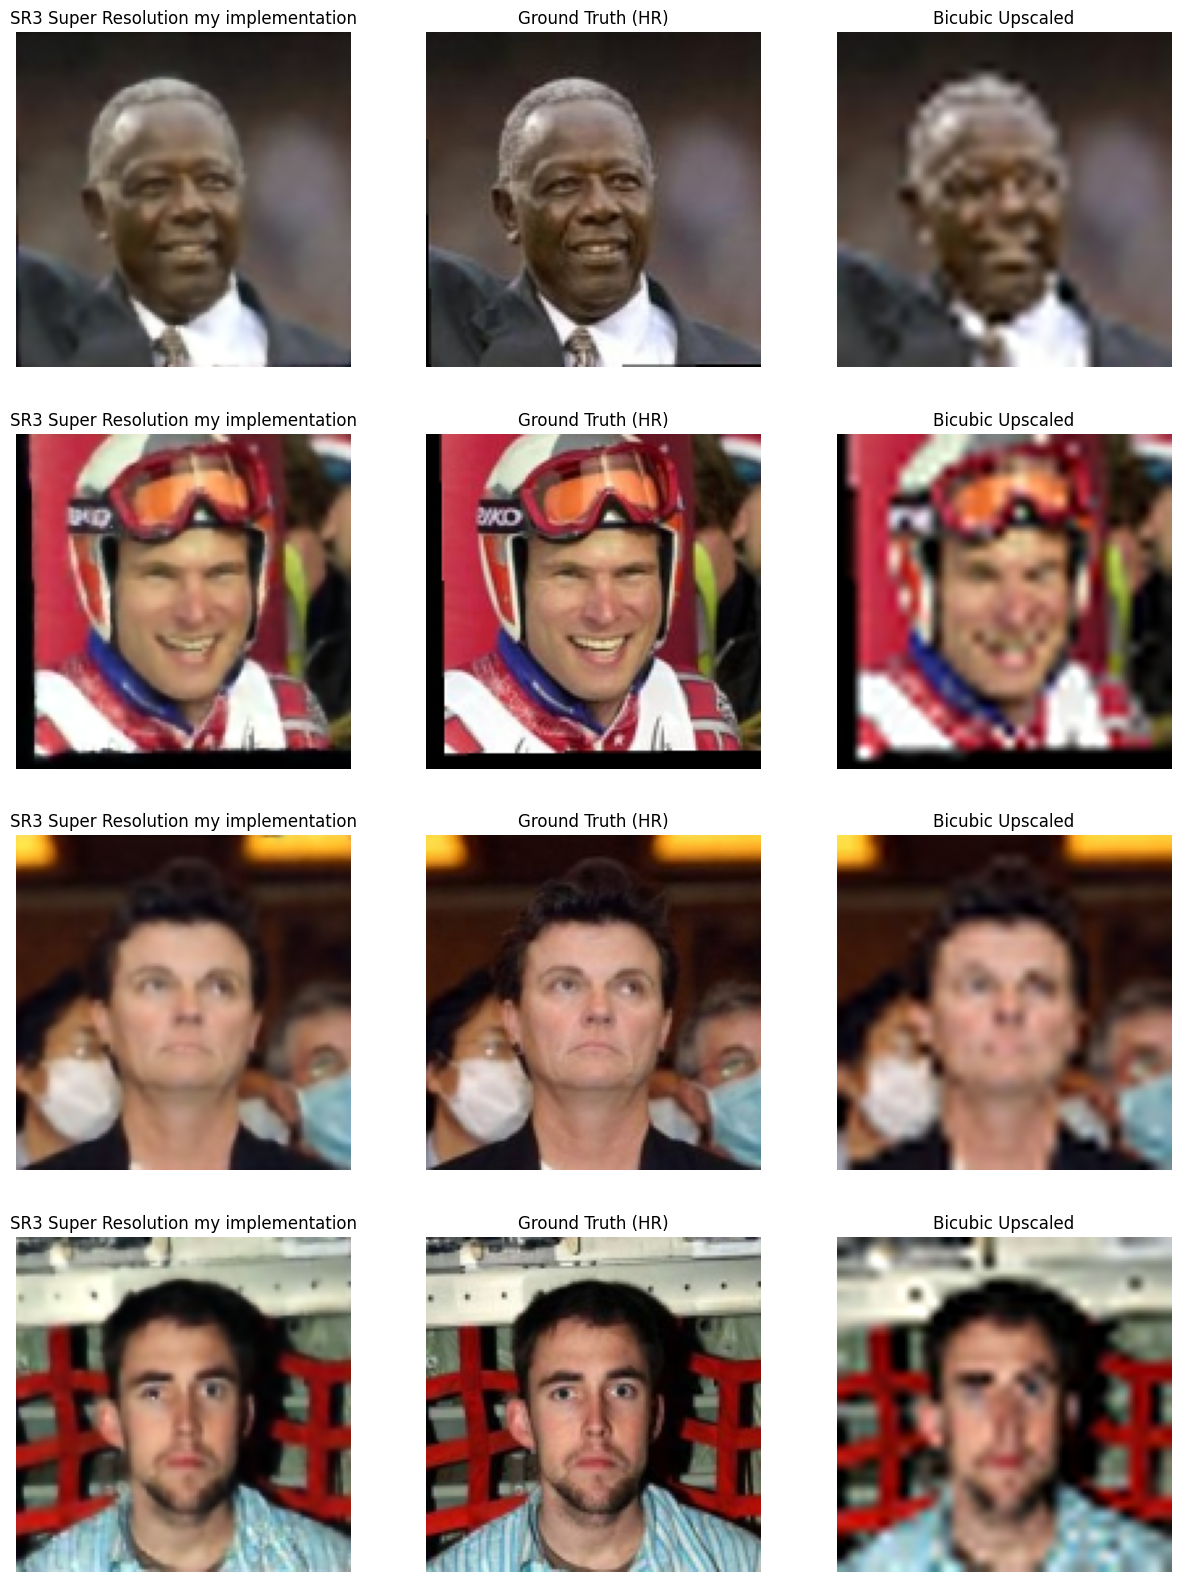

In [9]:
# Create a figure and axis for the plots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

for i in range(4):
    # Display x1[i] on the first axis
    axes[i][0].imshow(x1[i])
    axes[i][0].set_title('SR3 Super Resolution my implementation')
    axes[i][0].axis('off')

    # Display hr_img[100+i] on the second axis
    axes[i][1].imshow(hr_img[97+i])
    axes[i][1].set_title('Ground Truth (HR)')
    axes[i][1].axis('off')

    # Display lr_img[100+i] on the third axis
    axes[i][2].imshow(lr_img[97+i])
    axes[i][2].set_title('Bicubic Upscaled')
    axes[i][2].axis('off')

# Show the plots
plt.show()